In [736]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

sizeFixed = (18,18)
channels = 1
#dsImages = "/export/home/digits/jupyter/chtseng/datasets/classed/18x18-cam-total/train"
dsImages = "/home/digits/jupyter/chtseng/datasets/classed/ds-gesture-20180712/train"
#testPath = "/export/home/digits/jupyter/chtseng/datasets/classed/18x18-cam-total/test"
testPath = "/home/digits/jupyter/chtseng/datasets/classed/ds-gesture-20180712/test"

fraction = 0.2
epoch = 100
batchSize = 256

randomSeed = 2018

In [737]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
#from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from keras.layers.normalization import BatchNormalization
#from datetime import datetime
from keras.utils import np_utils
#from keras.optimizers import SGD
#from keras.models import Model
#from keras.layers import Input
#from keras.optimizers import Adam
from keras.layers import Dropout
#from IPython.display import display
#from PIL import Image
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import cv2
import numpy as np

from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers
import glob
import random


In [738]:
#Lable的對應, 每個Lable對應到一個數值

#dict_labels = {"nobody": 0,"body": 1, "chair": 2, "head": 3}
#dict_labels = { "none": 0,"sitting": 1, "standing": 2, "walking": 3 }
dict_labels = { "A": 0,"B": 1, "C": 2 }

In [739]:
def reshaped_image(image):
    return transform.resize(image,(sizeFixed[0], sizeFixed[1], channels)) # (cols (width), rows (height)) and don't use np.resize()

def load_images_from_folder(folder):    
    labels = []
    images = []
    
    for folders in glob.glob(folder+"/*"):
        #print("Load {} ...".format(folders))
        label = os.path.basename(folders)

        for filename in os.listdir(folders):  

            if label is not None:
                #print(dict_labels[label])
                img = cv2.imread(os.path.join(folder,folders,filename))
                if img is not None:            
                    img = reshaped_image(img)
                    labels.append(dict_labels[label])
                    images.append(np.array(img))
                    
    return np.array(images), np.array(labels)

def split_train_test(train_data, train_labels, fraction):
    
    #train_data = train_data.astype('float32') / 255.0
    
    np.random.seed(1024)
    num = len(train_data)
    
    index = list(range(num))
    
    random.shuffle(index)
    train_data = train_data[index]
    train_labels = train_labels[index]
    splitpoint = int(round(num * (1-fraction)))
    (X_train, X_test) = (train_data[0:splitpoint], train_data[splitpoint:])
    (y_train, y_test) = (train_labels[0:splitpoint], train_labels[splitpoint:])

    
    
    #X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=fraction, random_state=42)
    return X_train, y_train, X_test, y_test


In [740]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=170, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [741]:
def cnn_18x18Gesture(size):
    from keras.regularizers import l2
    shape = (size[0], size[1], size[2])
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=shape, W_regularizer=l2(0.01)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(dict_labels), activation = "softmax"))
    
    optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

    #sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile( loss = "binary_crossentropy",  optimizer = sgd,  metrics=['accuracy'] ) 
    
    #------------------------------------------------------------------------------
    
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    #model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])    

    #model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adadelta(), metrics=['accuracy'])
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)   
    #model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    #model.compile(optimizer = optimizer , loss = "cosine_proximity", metrics=["accuracy"])
    
    #optimizer = optimizers.Nadam()    
    #model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    #optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.001)
    #model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    #sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    

    
             
    model.summary()
    return model

In [742]:
train_data, train_labels = load_images_from_folder(dsImages)

train_data, train_labels, test_data, test_labels = split_train_test(train_data, train_labels, fraction)
datagen.fit(train_data)
#datagen.fit(test_data)

print("--> {}".format( train_data.shape))
print("--> {}".format( test_data.shape))

--> (2116, 18, 18, 1)
--> (529, 18, 18, 1)


In [743]:
train_labels = np_utils.to_categorical(train_labels, len(dict_labels))
test_labels = np_utils.to_categorical(test_labels, len(dict_labels))

#train_data = train_data.astype('float32') / 255.0
#test_data = test_data.astype('float32') / 255.0
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

Train data size:  2116
Test data size:  529


In [744]:


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

cnn = mnist1(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]))
#cnn = cnnModel(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]), n_layers=2)
#cnn = SqueezeNet(len(dict_labels), input_shape=([sizeFixed[0], sizeFixed[1], 3]))

#Resnet
#cnn = ResnetBuilder.build_resnet_101((3, sizeFixed[0], sizeFixed[1]), len(dict_labels))
#cnn.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])
#end Resnet

#VGG16
#cnn = VGG16([sizeFixed[0], sizeFixed[1]], len(dict_labels), trained=False)


print ("Train data shape: ", train_data.shape)
print ("Test data shape: ", test_data.shape)

#h = cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize),
#                              epochs = epoch, validation_data = (test_data,test_labels),
#                              verbose = 1, steps_per_epoch=train_data.shape[0] // batchSize
#                              , callbacks=[learning_rate_reduction],)

h = cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize), samples_per_epoch=2000,
                              epochs = epoch, validation_data = (datagen.flow(test_data,test_labels, batch_size=batchSize)),
                              verbose = 1 , callbacks=[learning_rate_reduction],)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_99 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_127 (Dropout)        (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_66 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 256)               803072    
__________

Epoch 47/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0914 - acc: 0.9702 - val_loss: 0.0601 - val_acc: 0.9849
Epoch 48/100
7/7 [==============================] - 0s 35ms/step - loss: 0.1118 - acc: 0.9702 - val_loss: 0.0817 - val_acc: 0.9723
Epoch 49/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1061 - acc: 0.9687
Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0001.
7/7 [==============================] - 0s 51ms/step - loss: 0.1034 - acc: 0.9704 - val_loss: 0.0633 - val_acc: 0.9842
Epoch 50/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0980 - acc: 0.9706 - val_loss: 0.0704 - val_acc: 0.9824
Epoch 51/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0940 - acc: 0.9673 - val_loss: 0.0442 - val_acc: 0.9924
Epoch 52/100
7/7 [==============================] - 0s 38ms/step - loss: 0.1057 - acc: 0.9656 - val_loss: 0.0442 - val_acc: 0.9937
Epoch 53/100
7/7 [==============================] - 0s 49ms/step - loss: 

In [745]:
final_loss, final_acc = cnn.evaluate(test_data, test_labels, verbose=0)

print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.023168, final accuracy: 0.998740


In [753]:
finaltest_data, finaltest_labels = load_images_from_folder(testPath)
finaltest_labels = np_utils.to_categorical(finaltest_labels, len(dict_labels))

#finaltest_data = finaltest_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(finaltest_data), axis=1)
predicted_test_labels = np_utils.to_categorical(predicted_test_labels, len(dict_labels))

print ("Actual test labels:", finaltest_labels)
print ("Predicted test labels:", predicted_test_labels)
print ("Accuracy score:", accuracy_score(finaltest_labels, predicted_test_labels))

Actual test labels: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 ..., 
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]
Predicted test labels: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 ..., 
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]
Accuracy score: 0.992110453649


In [754]:
X_val = finaltest_data
Y_val = finaltest_labels

print(test_data.shape)
print(test_labels.shape)
print(finaltest_data.shape)
print(finaltest_labels.shape)

(529, 18, 18, 1)
(529, 3)
(507, 18, 18, 1)
(507, 3)


In [761]:
from sklearn.metrics import classification_report

pred = cnn.predict(finaltest_data, batch_size=batchSize, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(finaltest_labels, axis=1), predicted)
print(report)

507/507 [==============================] - 0s 33us/step
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       135
          1       0.99      1.00      0.99       208
          2       0.99      0.98      0.99       164

avg / total       0.99      0.99      0.99       507



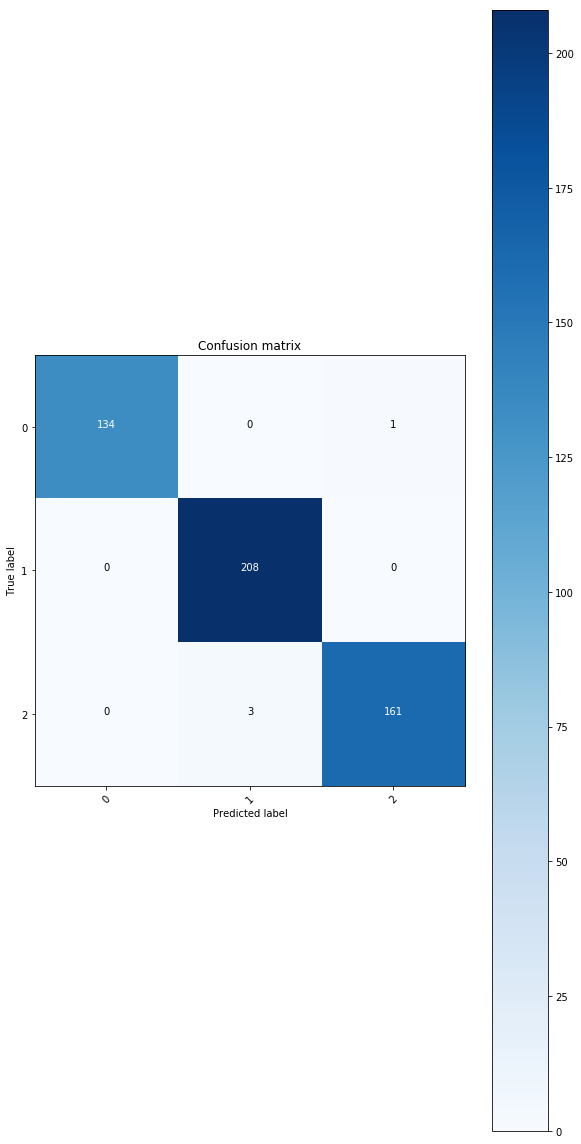

In [756]:
from sklearn.metrics import confusion_matrix
import itertools

# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(len(dict_labels)))

In [757]:
# serialize model to JSON
model_json = cnn.to_json()
with open("18x18_epoch_100_adam_data_2000.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("18x18_epoch_100_adam_data_2000.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


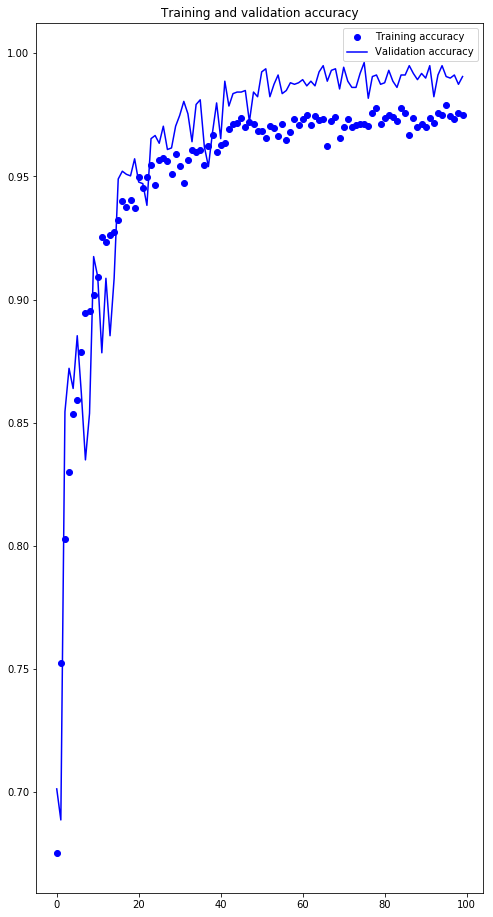

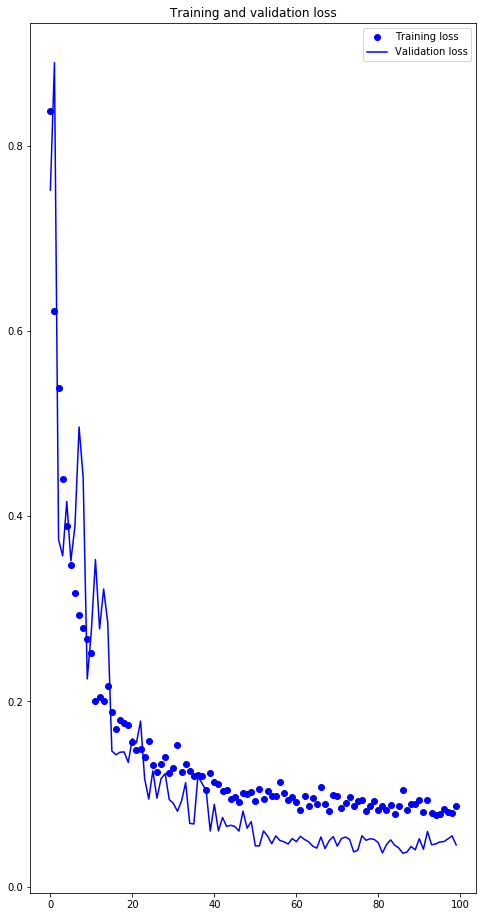

In [758]:
print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

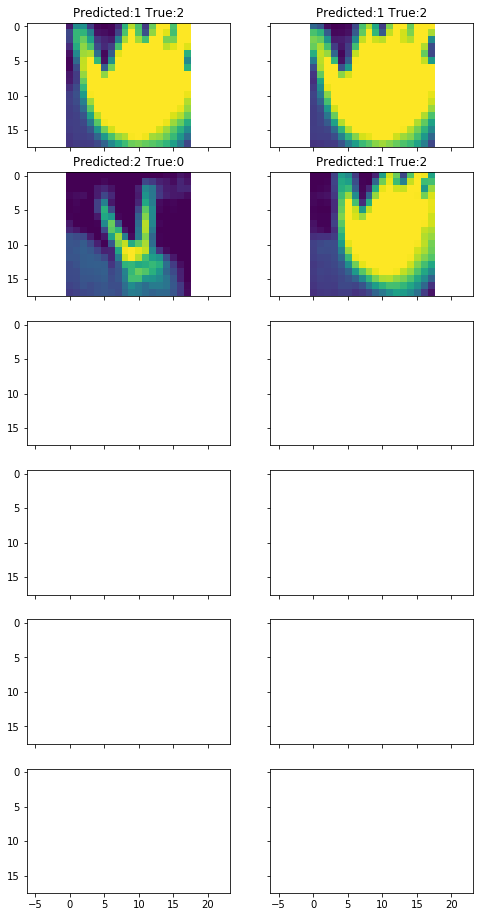

In [759]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

plt.rcParams["figure.figsize"] = [8,16]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 6
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    
    

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((18,18)))
            ax[row,col].set_title("Predicted:{} True:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

TypeError: Image data cannot be converted to float

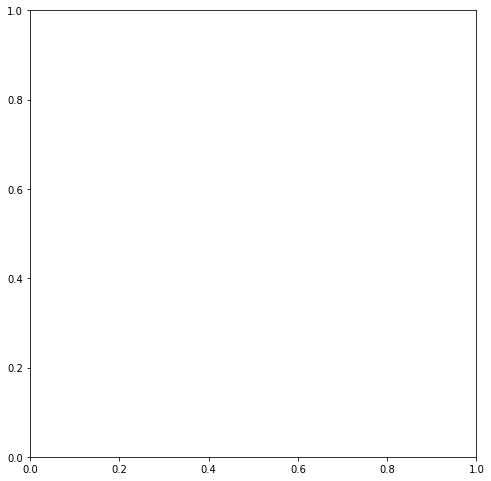

In [760]:
test_image = []
img = cv2.imread("/home/chtseng/works/train-opencvCascade/datasets/classed/18x18-3-gestures-step2/test/A/AUA055_0705_0432.bmp")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_3202.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_2107.jpg")
plt.imshow(img)
test_image.append(reshaped_image(img))
test_image = np.array(test_image)
print(test_image.shape)

test_image = test_image.astype('float32') / 255.0
#result = loaded_model.predict(test_image)
img_class = cnn.predict(test_image)
#prediction = img_class[0]
print(img_class)